<a href="https://colab.research.google.com/github/sayandas96476/gemstone-identification-using-deep-learning-approach/blob/main/VGG-16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -u /content/drive/MyDrive/test.zip -d /content
!unzip -u /content/drive/MyDrive/train.zip -d /content

Archive:  /content/drive/MyDrive/test.zip
Archive:  /content/drive/MyDrive/train.zip


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
from sklearn.metrics import confusion_matrix


In [ ]:
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
train_path = '/content/train'
test_path = '/content/test'
BATCH_SIZE = 64
IMG_SIZE = 224 
seed=123
input_shape = (IMG_SIZE,IMG_SIZE)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
 
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,\
                                   rotation_range=15, shear_range=10,\
                                   zoom_range=0.1, fill_mode='nearest', \
                                   height_shift_range=0.05, width_shift_range=0.1)


valid_gen = valid_datagen.flow_from_directory(directory=train_path,subset='validation',
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    interpolation='nearest'
)

train_gen = train_datagen.flow_from_directory(subset='training',
    directory=train_path,
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    interpolation='nearest'
)

Found 543 images belonging to 87 classes.
Found 2313 images belonging to 87 classes.


In [ ]:
n_classes=87

In [ ]:
class_indices = train_gen.class_indices

In [ ]:
temp_df = pd.DataFrame({'class': train_gen.classes}).value_counts().reset_index().sort_values(by='class')

temp_df.columns = ['class', 'counts']

Number of images:  2313


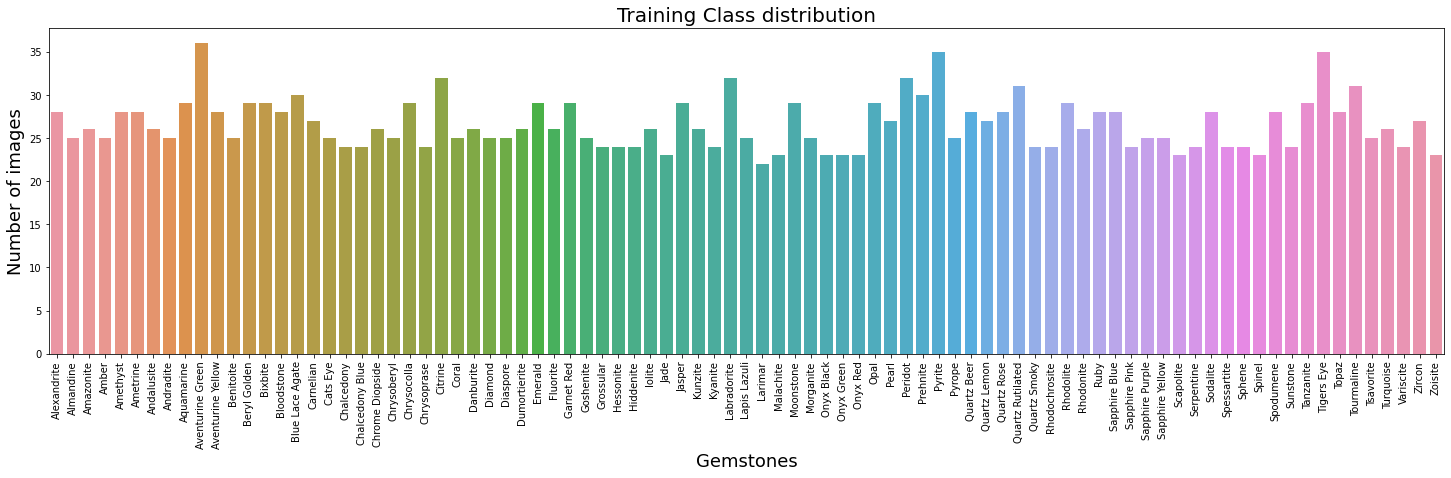

In [ ]:
plt.figure(figsize=(25,6))
sns.barplot(data=temp_df,
            x='class',
            y='counts')
plt.ylabel('Number of images', fontsize=18)
plt.xlabel('Gemstones', fontsize=18)
plt.title('Training Class distribution', fontsize=20)
plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)

print('Number of images: ', np.sum(temp_df['counts'].values))

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
  layer.trainable = False


In [ ]:
x = Flatten()(vgg.output)

prediction = Dense(87, activation='softmax')(x)

In [ ]:
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.metrics import TopKCategoricalAccuracy
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy',TopKCategoricalAccuracy(3, "top-3 accuracy"), TopKCategoricalAccuracy(5, "top-5 accuracy")]
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping

In [ ]:

checkpoint_path = "/content/drive/MyDrive/vgg16/weights.ckpt"

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
#Early Stopping
earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=0,
    mode='min')

history_cb = CSVLogger('/content/drive/MyDrive/vgg16/log.csv', separator=",", append=False)

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy',TopKCategoricalAccuracy(3, "top-3 accuracy"), TopKCategoricalAccuracy(5, "top-5 accuracy")]
)

In [ ]:
r = model.fit(
  train_gen,
  validation_data=valid_gen,
  epochs=30,
  callbacks=[history_cb,earlystopping_cb,cp_callback]
)

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 4.3261 - accuracy: 0.1747 - top-3 accuracy: 0.3087 - top-5 accuracy: 0.3822
Epoch 1: val_accuracy improved from -inf to 0.23757, saving model to /content/drive/MyDrive/vgg16/weights.ckpt
37/37 [==============================] - 34s 907ms/step - loss: 4.3261 - accuracy: 0.1747 - top-3 accuracy: 0.3087 - top-5 accuracy: 0.3822 - val_loss: 3.3952 - val_accuracy: 0.2376 - val_top-3 accuracy: 0.4254 - val_top-5 accuracy: 0.5267
Epoch 2/30
37/37 [==============================] - ETA: 0s - loss: 1.7347 - accuracy: 0.5629 - top-3 accuracy: 0.7402 - top-5 accuracy: 0.8080
Epoch 2: val_accuracy improved from 0.23757 to 0.36648, saving model to /content/drive/MyDrive/vgg16/weights.ckpt
37/37 [==============================] - 30s 798ms/step - loss: 1.7347 - accuracy: 0.5629 - top-3 accuracy: 0.7402 - top-5 accuracy: 0.8080 - val_loss: 2.5864 - val_accuracy: 0.3665 - val_top-3 accuracy: 0.5451 - val_top-5 accuracy: 0.6630
Epoch 3

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(directory=test_path,
                                            target_size = (224, 224),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 363 images belonging to 87 classes.


In [ ]:
checkpoint_path = "/content/drive/MyDrive/vgg16/weights.ckpt"
model.load_weights(checkpoint_path)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy',TopKCategoricalAccuracy(3, "top-3 accuracy"), TopKCategoricalAccuracy(5, "top-5 accuracy")]
)
# Re-evaluate the model
loss, acc, top3_acc, top5_acc = model.evaluate(test_set)
print("Restored model from checkpoint, accuracy: {:5.2f}%".format(100 * acc))
print("top 3_accuracy= , top 5_accuracy=",top3_acc, top5_acc)

6/6 [==============================] - 2s 280ms/step - loss: 2.0189 - accuracy: 0.5482 - top-3 accuracy: 0.7355 - top-5 accuracy: 0.7934
Restored model from checkpoint, accuracy: 54.82%
top 3_accuracy= , top 5_accuracy= 0.7355371713638306 0.7933884263038635


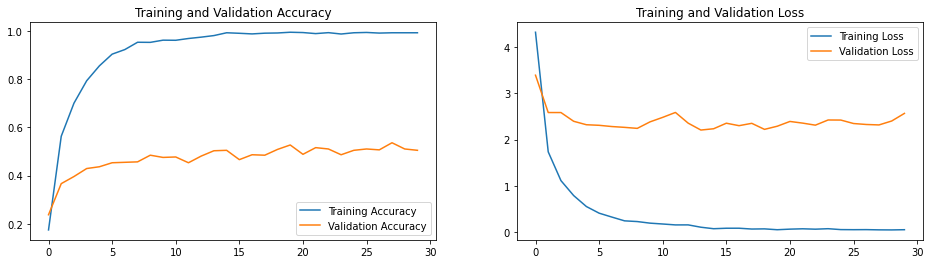

In [ ]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss'] 
val_loss = r.history['val_loss'] 
plt.figure(figsize=(16, 4)) 
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy') 
plt.plot(val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy') 
plt.subplot(1, 2, 2) 
plt.plot(loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.show()

In [ ]:
def plot_confusion_matrix(data_gen, title=''):
    n_batches = int(np.ceil(data_gen.n/BATCH_SIZE))
    classes_df = pd.DataFrame()

    for batch in np.arange(n_batches):
        classes = np.argmax(data_gen[batch][1], axis=1)
        temp_df = pd.DataFrame(classes)
        classes_df = classes_df.append(temp_df, ignore_index=True)
    classes_df.columns = ['true_class']

    #logits and probs
    logits = model.predict(data_gen)
    probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()

    classes_df['predicted_class'] = np.argmax(probs, axis=1)
    
    conf_matrix = confusion_matrix(classes_df.true_class.values, 
                                    classes_df.predicted_class.values, 
                                    labels=np.arange(n_classes))
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)
    
    plt.figure(figsize=(40,30))
    sns.heatmap(conf_matrix_norm, 
                cmap='viridis',
                annot=conf_matrix_norm,
                vmin=0, vmax=1,)
    _ = plt.title(title, fontsize=25)
    _ = plt.yticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=0)
    _ = plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)

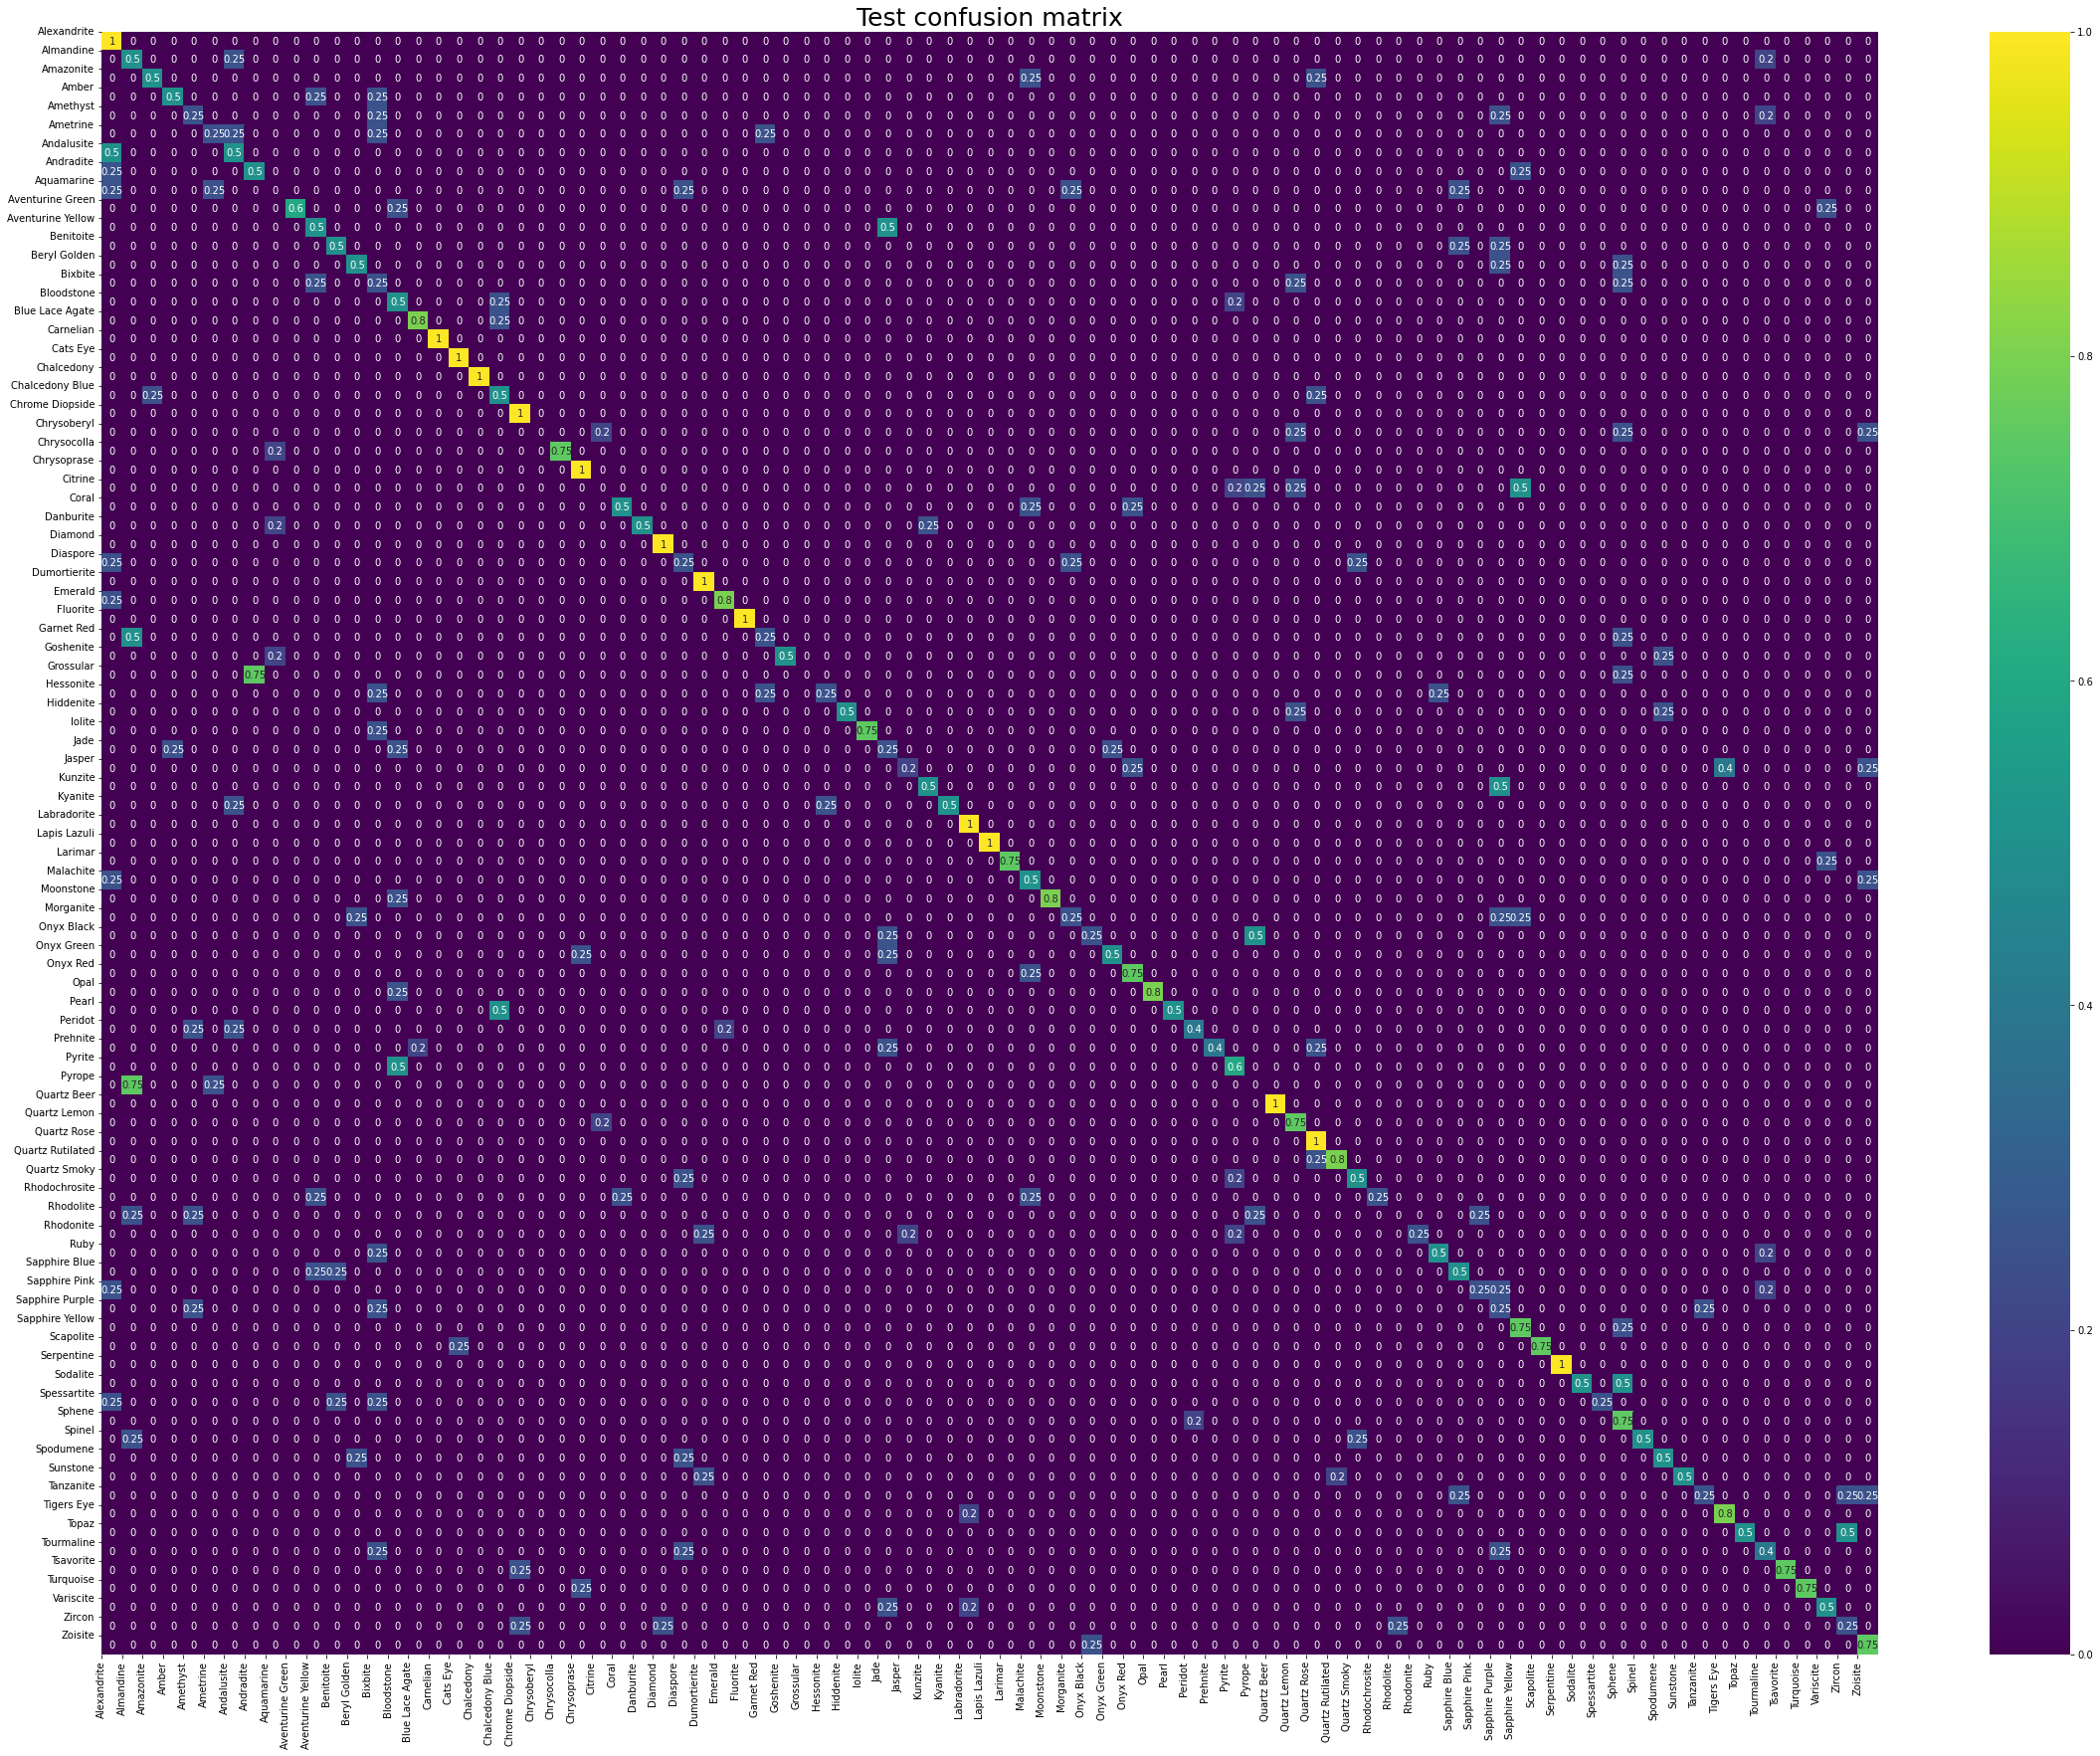

In [ ]:
plot_confusion_matrix(test_set, 'Test confusion matrix')

In [ ]:
n_batches = int(np.ceil(test_set.n/BATCH_SIZE))
classes_df = pd.DataFrame()

for batch in np.arange(n_batches):
    classes = np.argmax(test_set[batch][1], axis=1)
    temp_df = pd.DataFrame(classes)
    classes_df = classes_df.append(temp_df, ignore_index=True)
classes_df.columns = ['true_class']

In [ ]:
#logits and probs
logits = model.predict(test_set)
probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()

classes_df['predicted_class'] = np.argmax(probs, axis=1)

In [ ]:
Y_true = classes_df["true_class"]
Y_pred = classes_df["predicted_class"]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(Y_true,Y_pred,average='weighted')
recall = recall_score(Y_true,Y_pred,average='weighted')
f1 = f1_score(Y_true,Y_pred,average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("precision: ",precision,"\nrecall: ",recall,"\nf1_score: ",f1)

precision:  0.615565426309228 
recall:  0.5482093663911846 
f1_score:  0.5476262236835887
